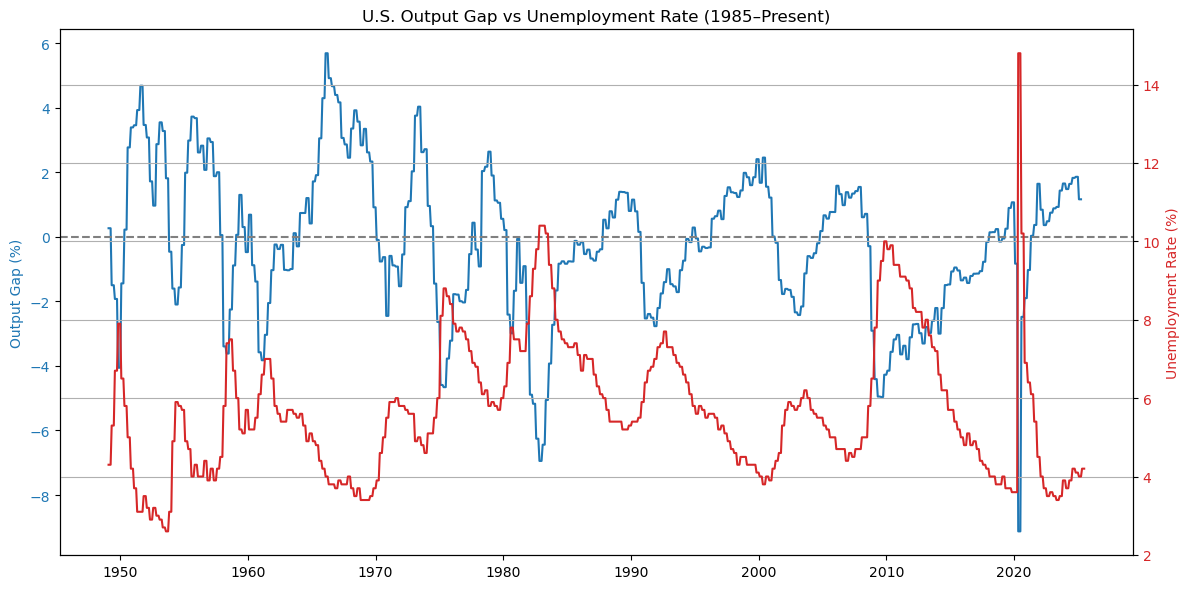

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

start_date = '1949-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# 下载数据
actual_gdp = pdr.DataReader('GDPC1', 'fred', start_date, end_date)
potential_gdp = pdr.DataReader('GDPPOT', 'fred', start_date, end_date)
unrate = pdr.DataReader('UNRATE', 'fred', start_date, end_date)

# 合并数据
df = pd.concat([actual_gdp, potential_gdp], axis=1)
df.columns = ['Actual_GDP', 'Potential_GDP']
df['Output_Gap'] = 100 * (df['Actual_GDP'] - df['Potential_GDP']) / df['Potential_GDP']
df['Unemployment_Rate'] = unrate

# 转换为月度数据
df_monthly = df.resample('M').ffill()

# 可视化：双轴图
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(df_monthly.index, df_monthly['Output_Gap'], label='Output Gap (%)', color='tab:blue')
ax1.set_ylabel('Output Gap (%)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.axhline(0, color='gray', linestyle='--')

ax2.plot(df_monthly.index, df_monthly['Unemployment_Rate'], label='Unemployment Rate (%)', color='tab:red')
ax2.set_ylabel('Unemployment Rate (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('U.S. Output Gap vs Unemployment Rate (1985–Present)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


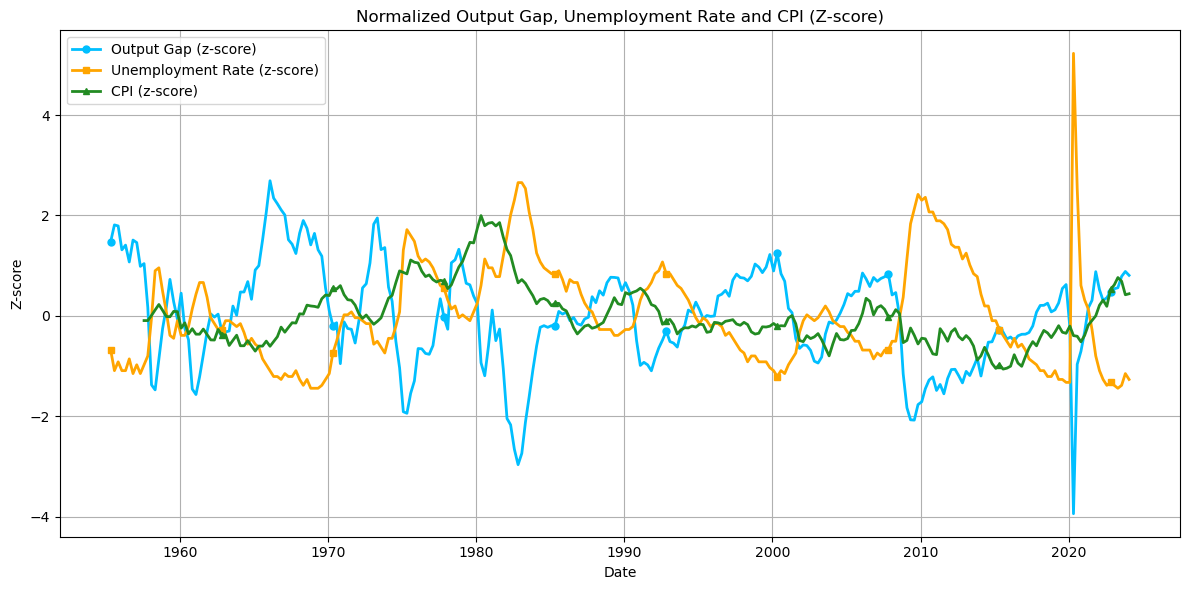

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr
from scipy.stats import zscore

start_date = '1949-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# 下载数据
actual_gdp = pdr.DataReader('GDPC1', 'fred', start_date, end_date)
potential_gdp = pdr.DataReader('GDPPOT', 'fred', start_date, end_date)
unrate = pdr.DataReader('UNRATE', 'fred', start_date, end_date)
cpi = pdr.DataReader('CPALTT01USM657N', 'fred', start_date, end_date)

# 合并数据
df = pd.concat([actual_gdp, potential_gdp, unrate, cpi], axis=1)
df.columns = ['Actual_GDP', 'Potential_GDP', 'Unemployment_Rate', 'CPI']
df['Output_Gap'] = 100 * (df['Actual_GDP'] - df['Potential_GDP']) / df['Potential_GDP']

# 转为月度数据，缺失值向前填充
df_monthly = df.resample('M').ffill().dropna()

# 对三列做 z-score 标准化
df_monthly['Output_Gap_z'] = zscore(df_monthly['Output_Gap'])
df_monthly['Unemployment_Rate_z'] = zscore(df_monthly['Unemployment_Rate'])
df_monthly['CPI_z'] = zscore(df_monthly['CPI'])

# 画图
plt.figure(figsize=(12,6))
plt.plot(df_monthly.index, df_monthly['Output_Gap_z'], label='Output Gap (z-score)',
         color='deepskyblue', linewidth=2, marker='o', markersize=5, markevery=30)
plt.plot(df_monthly.index, df_monthly['Unemployment_Rate_z'], label='Unemployment Rate (z-score)',
         color='orange', linewidth=2, marker='s', markersize=5, markevery=30)
window_size = 10
smoothed_series = df_monthly['CPI_z'].rolling(window=window_size).mean()
plt.plot(df_monthly.index, smoothed_series, label='CPI (z-score)',
         color='forestgreen', linewidth=2, marker='^', markersize=5, markevery=30)
# plt.plot(df_monthly.index, df_monthly['CPI_z'], label='CPI (z-score)',
#          color='forestgreen', linewidth=2, marker='^', markersize=5, markevery=30)

plt.title('Normalized Output Gap, Unemployment Rate and CPI (Z-score)')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


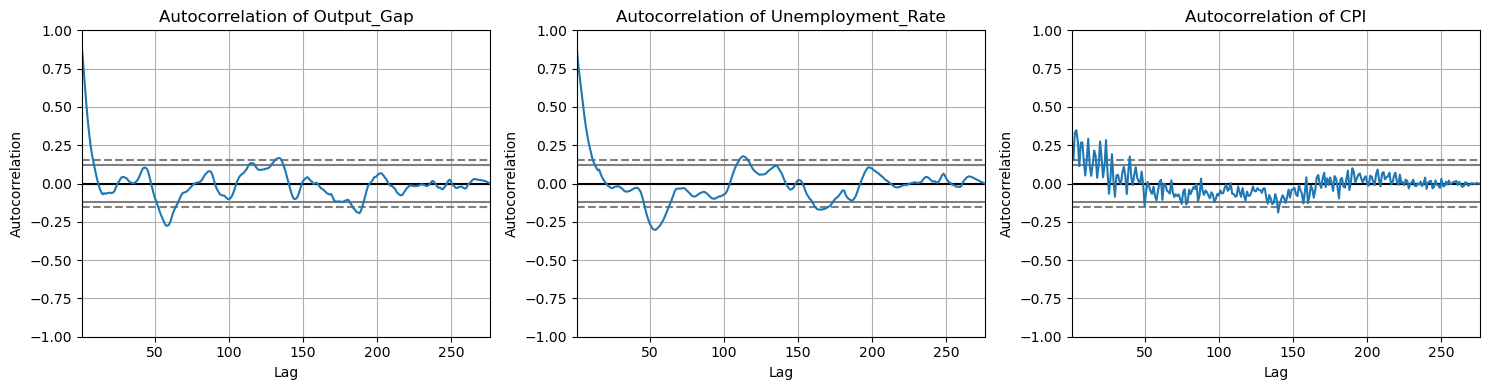

In [3]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(15, 4))
for i, col in enumerate(['Output_Gap', 'Unemployment_Rate', 'CPI']):
    plt.subplot(1, 3, i+1)
    autocorrelation_plot(df_monthly[col])
    plt.title(f'Autocorrelation of {col}')
plt.tight_layout()
plt.show()


使用的是月度数据，横轴表示滞后几期

In [4]:
# 提取需要的列
macro_z = df_monthly[['Output_Gap_z', 'Unemployment_Rate_z', 'CPI_z']]

# 计算相关性矩阵
corr_matrix = macro_z.corr(method='pearson')

# 打印结果
print(corr_matrix)


                     Output_Gap_z  Unemployment_Rate_z     CPI_z
Output_Gap_z             1.000000            -0.821206  0.148171
Unemployment_Rate_z     -0.821206             1.000000 -0.062630
CPI_z                    0.148171            -0.062630  1.000000


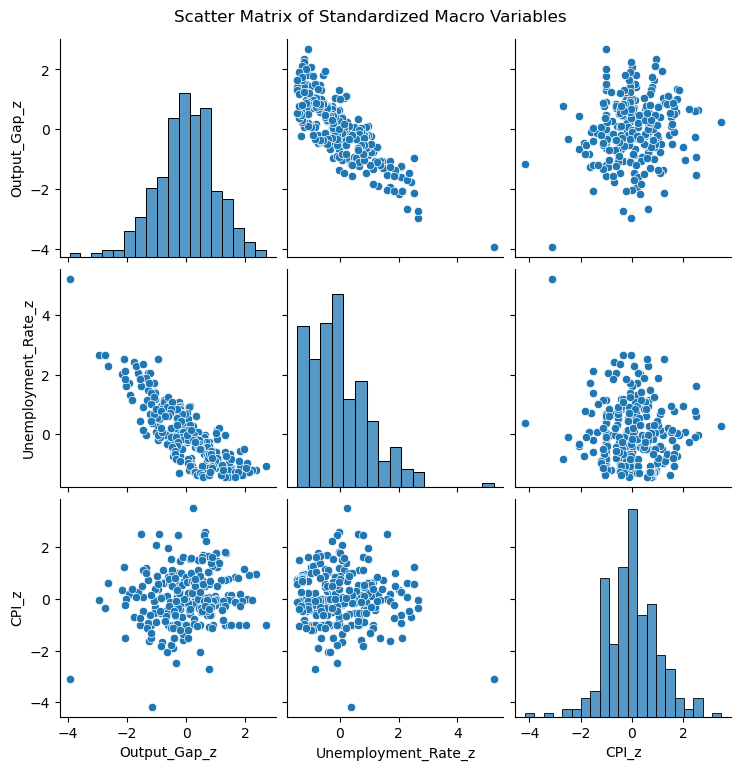

In [6]:
import seaborn as sns

sns.pairplot(macro_z)
plt.suptitle("Scatter Matrix of Standardized Macro Variables", y=1.02)
plt.show()


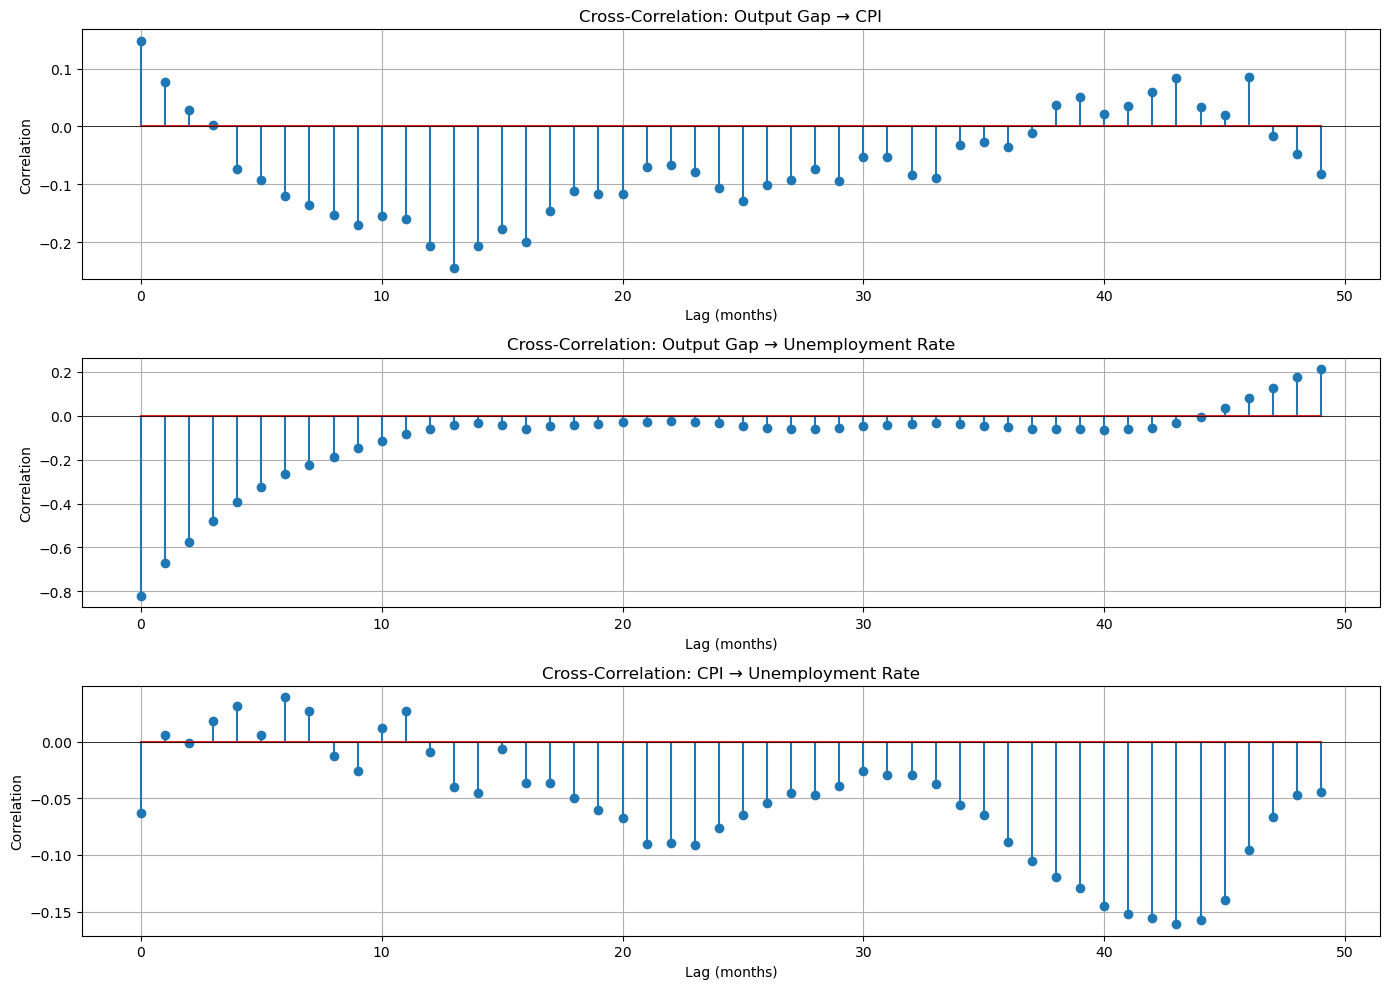

In [ ]:
from statsmodels.tsa.stattools import ccf

# 准备数据
x1 = df_monthly['Output_Gap_z'] - df_monthly['Output_Gap_z'].mean()
y1 = df_monthly['CPI_z'] - df_monthly['CPI_z'].mean()
x2 = df_monthly['Output_Gap_z'] - df_monthly['Output_Gap_z'].mean()
y2 = df_monthly['Unemployment_Rate_z'] - df_monthly['Unemployment_Rate_z'].mean()
x3 = df_monthly['CPI_z'] - df_monthly['CPI_z'].mean()
y3 = df_monthly['Unemployment_Rate_z'] - df_monthly['Unemployment_Rate_z'].mean()

ccf1 = ccf(x1, y1)
ccf2 = ccf(x2, y2)
ccf3 = ccf(x3, y3)

# 绘图
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.stem(range(len(ccf1[:50])), ccf1[:50])
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Cross-Correlation: Output Gap → CPI')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.stem(range(len(ccf2[:50])), ccf2[:50])
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Cross-Correlation: Output Gap → Unemployment Rate')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.stem(range(len(ccf3[:50])), ccf3[:50])
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Cross-Correlation: CPI → Unemployment Rate')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')
plt.grid(True)

plt.tight_layout()
plt.show()

🔍 Top 2 Peak Frequencies and Corresponding Periods:
Peak 1: Frequency = 0.0254, Amplitude = 78.7225, Period = 39.43 time units
Peak 2: Frequency = 0.0072, Amplitude = 77.3389, Period = 138.00 time units


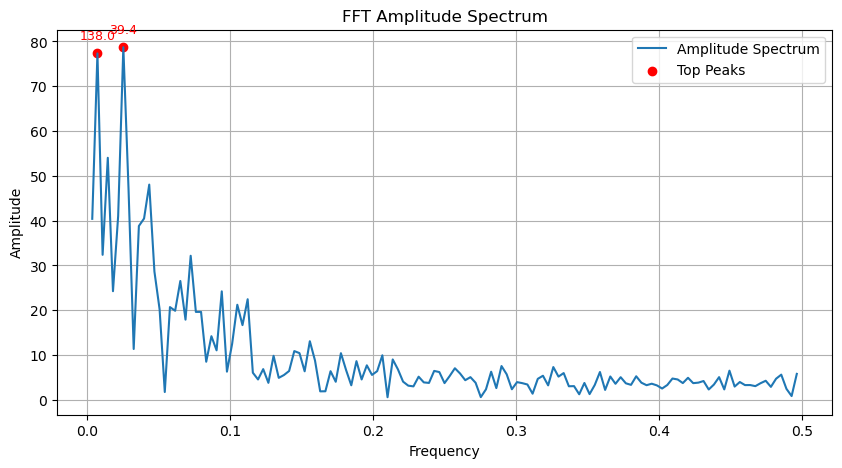

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Fourier Transform
x = df_monthly['Output_Gap_z'].dropna().values
n = len(x)
fft_result = np.fft.fft(x)
freqs = np.fft.fftfreq(n)

# 只取前一半正频率部分（跳过频率=0项）
positive_freqs = freqs[1:n//2]
amplitudes = np.abs(fft_result[1:n//2])  # 跳过 DC 成分（频率=0）

# 找出前两个最大的峰值的索引
top_two_idx = np.argpartition(amplitudes, -2)[-2:]
top_two_idx = top_two_idx[np.argsort(amplitudes[top_two_idx])[::-1]]  # 降序排序

# 输出两个峰的信息
print("🔍 Top 2 Peak Frequencies and Corresponding Periods:")
for i, idx in enumerate(top_two_idx):
    freq = positive_freqs[idx]
    amp = amplitudes[idx]
    period = 1 / freq if freq != 0 else np.inf
    print(f"Peak {i+1}: Frequency = {freq:.4f}, Amplitude = {amp:.4f}, Period = {period:.2f} time units")

# 可视化
plt.figure(figsize=(10, 5))
plt.plot(positive_freqs, amplitudes, label='Amplitude Spectrum')
plt.scatter(positive_freqs[top_two_idx], amplitudes[top_two_idx], color='red', label='Top Peaks')

for idx in top_two_idx:
    plt.annotate(f"{1/positive_freqs[idx]:.1f}", 
                 (positive_freqs[idx], amplitudes[idx]), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='red')

plt.title("FFT Amplitude Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# 1. 下载数据
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

actual_gdp = pdr.DataReader('GDPC1', 'fred', start_date, end_date)
potential_gdp = pdr.DataReader('GDPPOT', 'fred', start_date, end_date)
unrate = pdr.DataReader('UNRATE', 'fred', start_date, end_date)
cpi = pdr.DataReader('CPALTT01USM657N', 'fred', start_date, end_date)
nber_recession = pdr.DataReader('USREC', 'fred', start_date, end_date)

# 2. 合并数据
df = pd.concat([actual_gdp, potential_gdp, unrate, cpi, nber_recession], axis=1)
df.columns = ['Actual_GDP', 'Potential_GDP', 'Unemployment_Rate', 'CPI', 'Recession']
df['Output_Gap'] = 100 * (df['Actual_GDP'] - df['Potential_GDP']) / df['Potential_GDP']
df = df.dropna()

# 3. 转为月度数据，缺失值前向填充
df_monthly = df.resample('M').ffill()

# 4. 滚动窗口评估函数
def rolling_window_evaluation(df, window_months=84):
    results = []
    for start in range(len(df) - window_months):
        window_data = df.iloc[start:start+window_months]
        X = window_data[['Output_Gap', 'Unemployment_Rate', 'CPI']]
        y = window_data['Recession']
        
        split_idx = int(len(window_data) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        
        # 跳过训练集中只有一个类别的窗口
        if y_train.nunique() < 2:
            continue
        
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        auc = roc_auc_score(y_test, y_prob)
        accuracy = (y_pred == y_test).mean()
        
        results.append({
            'start_date': window_data.index[0],
            'end_date': window_data.index[-1],
            'roc_auc': auc,
            'accuracy': accuracy
        })
    return pd.DataFrame(results)

# 5. 执行滚动窗口评估（7年窗口）
results_7y = rolling_window_evaluation(df_monthly, window_months=84)

# 6. 结果可视化
plt.figure(figsize=(14,6))
plt.plot(results_7y['start_date'], results_7y['roc_auc'], label='7-Year Window ROC AUC')
plt.plot(results_7y['start_date'], results_7y['accuracy'], label='7-Year Window Accuracy')
plt.xlabel('Window Start Date')
plt.title('Rolling Window Logistic Regression Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np

# 去掉 NaN（保险做法）
analysis_df = df_monthly[['Output_Gap', 'Unemployment_Rate']].dropna()

# 1. 散点图
plt.figure(figsize=(8, 6))
sns.regplot(data=analysis_df, x='Output_Gap', y='Unemployment_Rate', line_kws={"color": "red"})
plt.title('Output Gap vs Unemployment Rate')
plt.xlabel('Output Gap (%)')
plt.ylabel('Unemployment Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 相关系数
corr_value, p_value = pearsonr(analysis_df['Output_Gap'], analysis_df['Unemployment_Rate'])
print(f"皮尔森相关系数: {corr_value:.3f}, P值: {p_value:.3g}")

# 3. 简单线性回归
X = analysis_df['Output_Gap'].values.reshape(-1, 1)
y = analysis_df['Unemployment_Rate'].values
model = LinearRegression().fit(X, y)
print(f"线性回归：失业率 = {model.intercept_:.3f} + {model.coef_[0]:.3f} * Output Gap")
print(f"R² = {model.score(X, y):.3f}")


In [ ]:
# 翻转失业率：方法1：取反
df_monthly['Inverted_Unrate'] = -df_monthly['Unemployment_Rate']

# 方法2（更直观）：最大值减去当前值
# max_unrate = df_monthly['Unemployment_Rate'].max()
# df_monthly['Inverted_Unrate'] = max_unrate - df_monthly['Unemployment_Rate']

# 可视化：双轴图（含翻转失业率）
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Output Gap 曲线（左轴）
ax1.plot(df_monthly.index, df_monthly['Output_Gap'], label='Output Gap (%)', color='tab:blue')
ax1.set_ylabel('Output Gap (%)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.axhline(0, color='gray', linestyle='--')

# 失业率翻转后曲线（右轴）
ax2.plot(df_monthly.index, df_monthly['Inverted_Unrate'], label='Inverted Unemployment Rate', color='tab:orange')
ax2.set_ylabel('Inverted Unemployment Rate', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('U.S. Output Gap vs Inverted Unemployment Rate (1985–Present)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 假设df_monthly已包含Output_Gap和Unemployment_Rate，且无缺失值
df_reg = df_monthly[['Output_Gap', 'Unemployment_Rate']].dropna()

# 准备特征X和目标y
X = df_reg['Output_Gap'].values.reshape(-1, 1)  # sklearn需要二维数组
y = df_reg['Unemployment_Rate'].values

# 建立线性回归模型
model = LinearRegression()
model.fit(X, y)

# 输出回归结果
print(f"截距（β0）：{model.intercept_:.4f}")
print(f"回归系数（β1）：{model.coef_[0]:.4f}")
print(f"模型R²：{model.score(X, y):.4f}")

# 预测值
y_pred = model.predict(X)

# 绘制回归散点图与拟合直线
plt.figure(figsize=(8,6))
plt.scatter(X, y, alpha=0.5, label='Real Data')
plt.plot(X, y_pred, color='red', label='Fitted Line')
plt.xlabel('Output Gap (%)')
plt.ylabel('Unemployment Rate (%)')
plt.title('Linear Regression: Unemployment Rate vs Output Gap')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# 1. 获取数据
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

actual_gdp = pdr.DataReader('GDPC1', 'fred', start_date, end_date)
potential_gdp = pdr.DataReader('GDPPOT', 'fred', start_date, end_date)
unrate = pdr.DataReader('UNRATE', 'fred', start_date, end_date)
nber_recession = pdr.DataReader('USREC', 'fred', start_date, end_date)

# 2. 合并数据
df = pd.concat([actual_gdp, potential_gdp, unrate, nber_recession], axis=1)
df.columns = ['Actual_GDP', 'Potential_GDP', 'Unemployment_Rate', 'Recession']
df['Output_Gap'] = 100 * (df['Actual_GDP'] - df['Potential_GDP']) / df['Potential_GDP']
df = df.dropna()

# 3. 划分训练测试集
train = df.loc[:'2015-12-31']
test = df.loc['2016-01-01':]

X_train = train[['Output_Gap', 'Unemployment_Rate']]
y_train = train['Recession']
X_test = test[['Output_Gap', 'Unemployment_Rate']]
y_test = test['Recession']

# 4. 训练逻辑回归
model = LogisticRegression()
model.fit(X_train, y_train)

# 5. 预测概率和类别
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# 6. 评估打印
print(classification_report(y_test, y_pred))
print('混淆矩阵:\n', confusion_matrix(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_prob))

# 7. 可视化真实与预测衰退区间概率和预测结果
plt.figure(figsize=(14,6))

plt.plot(test.index, y_test, label='Recession', color='black', linestyle='-', alpha=0.7)
plt.plot(test.index, y_prob, label='Predicted Prob', color='blue', alpha=0.7)
plt.plot(test.index, y_pred, label='Predicted Type', color='red', linestyle='--', alpha=0.7)

plt.title('US Recession Prediction(Real vs Predicted)')
plt.xlabel('date')
plt.ylabel('Recession / Probability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC 曲线 (AUC = {roc_auc_score(y_test, y_prob):.2f})', color='green')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df_monthly.index, df_monthly["Output_Gap"], label="Output Gap", color="blue")
plt.axhline(0, color="gray", linestyle="--")
nber_cycles = [
    ("1985-01", "1989-01", "Expansion"),
    ("1989-01", "1990-01", "Peak"),
    ("1990-01", "1991-01", "Contraction"),
    ("1991-01", "1992-01", "Trough"),

    ("1992-01", "1999-01", "Expansion"),
    ("1999-01", "2001-01", "Peak"),
    ("2001-01", "2002-07", "Contraction"),
    ("2002-07", "2003-05", "Trough"),

    ("2003-05", "2006-01", "Expansion"),
    ("2006-01", "2008-01", "Peak"),
    ("2008-01", "2009-01", "Contraction"),
    ("2009-01", "2009-12", "Trough"),
    
    ("2009-12", "2020-02", "Expansion"),
    ("2020-02", "2020-09", "Trough"),
    ("2020-09", "2021-07", "Expansion"),
    ("2021-07", "2025-01", "Peak"),

]
cycle_colors = {
    "Expansion": "#a6d854",
    "Contraction": "#fc8d62",
    "Peak": "#8da0cb",
    "Trough": "#66c2a5" 
}

for start, end, label in nber_cycles:
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    plt.axvspan(start_date, end_date, color=cycle_colors[label], alpha=0.3,
                label=label if plt.gca().get_legend_handles_labels()[1].count(label) == 0 else None)
    plt.text((start_date + (end_date - start_date) / 2), df_monthly["Output_Gap"].max() + 0.5,
             label, ha="center", va="bottom", fontsize=8)

plt.title("U.S. Output Gap with NBER Business Cycle Phases")
plt.xlabel("Date")
plt.ylabel("Output Gap (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from collections import defaultdict

# === Step 1: Load EPS data ===

df_eps = pd.read_excel("Top_20_US_Companies_EPS.xlsx")
df_eps['Date'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(df_eps['Dates'], unit='D')
df_eps = df_eps.drop(columns='Dates').set_index('Date')

# === Step 2: Load sector mapping ===
df_sector = pd.read_excel("Top_20_US_Companies_By_Sector_With_Bloomberg_Tickers.xlsx")
ticker_to_sector = dict(zip(df_sector['Bloomberg_Ticker'], df_sector['Sector']))

# === Step 3: Define business cycle phases ===
business_cycles = [
    ("1985-01", "1989-01", "Expansion"),
    ("1989-01", "1990-01", "Peak"),
    ("1990-01", "1991-01", "Contraction"),
    ("1991-01", "1992-01", "Trough"),
    ("1992-01", "1999-01", "Expansion"),
    ("1999-01", "2001-01", "Peak"),
    ("2001-01", "2002-07", "Contraction"),
    ("2002-07", "2003-03", "Trough"),
    ("2003-03", "2006-01", "Expansion"),
    ("2006-01", "2008-01", "Peak"),
    ("2008-01", "2009-01", "Contraction"),
    ("2009-01", "2009-12", "Trough"),
    ("2009-12", "2020-02", "Expansion"),
    ("2020-02", "2020-09", "Trough"),
    ("2020-09", "2021-07", "Expansion"),
    ("2021-07", "2025-01", "Peak"),
]

# === Step 4: Group periods by phase ===
phase_periods = defaultdict(list)
for start, end, phase in business_cycles:
    phase_periods[phase].append((pd.to_datetime(start), pd.to_datetime(end)))

# === Step 5: Compute average EPS for each sector and cycle phase ===
final_results = []

for phase, periods in phase_periods.items():
    # Merge time periods within the same phase
    df_phase = pd.DataFrame()
    for start_date, end_date in periods:
        df_slice = df_eps[(df_eps.index >= start_date) & (df_eps.index < end_date)]
        df_phase = pd.concat([df_phase, df_slice])

    # Calculate sector-level average EPS
    sector_eps = defaultdict(list)
    for ticker in df_phase.columns:
        sector = ticker_to_sector.get(ticker)
        if sector:
            sector_eps[sector].append(df_phase[ticker])

    for sector, eps_series in sector_eps.items():
        combined = pd.concat(eps_series, axis=1)
        avg_eps = combined.mean(axis=1, skipna=True).mean(skipna=True)
        if pd.notna(avg_eps):
            final_results.append({
                "Sector": sector,
                "Cycle_Phase": phase,
                "Average_EPS": avg_eps
            })

# === Step 6: Save or print results ===
df_result = pd.DataFrame(final_results)
print(df_result)
# df_result.to_excel("Sector_EPS_by_Cycle.xlsx", index=False)

In [ ]:
# Step 1: 聚合（防止重复组合）
df_cleaned = df_result.groupby(["Sector", "Cycle_Phase"]).mean(numeric_only=True).reset_index()

# Step 2: Pivot 成行业 × 周期的结构
df_pivot = df_cleaned.pivot(index="Sector", columns="Cycle_Phase", values="Average_EPS")

# Step 3: 按你希望的顺序排列列
df_pivot = df_pivot[["Expansion", "Peak", "Contraction", "Trough"]]

# Step 4: 输出结果（可视化或保存）
print(df_pivot)

In [ ]:
# 设置时间区间
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# === 1. M2 YoY 增速 ===
m2 = pdr.DataReader('M2SL', 'fred', start_date, end_date)
m2_yoy = m2.pct_change(periods=12) * 100
m2_yoy.rename(columns={'M2SL': 'M2_YoY'}, inplace=True)

In [ ]:
m2_yoy.index = m2_yoy.index.to_period('M').to_timestamp()
df_monthly.index = df_monthly.index.to_period('M').to_timestamp()  # 你原来的 Output Gap

df_all = pd.concat([
    m2_yoy,
    df_monthly[['Output_Gap']]
], axis=1)

df_all = df_all.loc['1990-01-01':]

df_clean = df_all.dropna()
df_standardized = (df_clean - df_clean.mean()) / df_clean.std()

plt.figure(figsize=(14, 6))
for col in df_standardized.columns:
    plt.plot(df_standardized.index, df_standardized[col], label=col, linewidth=2)

plt.title("Standardized Macro Indicators (Z-Score) — 1990–Present")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.axhline(0, linestyle='--', color='gray')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_tb = pd.read_csv("fredgraph.csv")

df_tb.columns = df_tb.columns.str.strip()
df_tb = df_tb.rename(columns={
    'observation_date': 'Date',
    'DGS10': 'TBill_10Y',
    'DTB6': 'TBill_6M'
})


df_tb['Date'] = pd.to_datetime(df_tb['Date'])

df_tb['10Y_minus_6M'] = df_tb['TBill_10Y'] - df_tb['TBill_6M']

df_tb['Date'] = pd.to_datetime(df_tb['Date'])
#figure 1
plt.figure(figsize=(14, 6))
plt.plot(df_tb['Date'], df_tb['TBill_6M'], label='6M Treasury Bill Rate (Discount Basis)', linestyle='--', color='purple')
plt.plot(df_tb['Date'], df_tb['TBill_10Y'], label='10Y Treasury Bill Rate', color='blue')
plt.axhline(0, color='black', linewidth=1)
plt.title("6M Treasury Bill Rate and Yield Spread (10Y - 2Y)")
plt.ylabel("Percent")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
#figure2
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(df_tb['Date'], df_tb['10Y_minus_6M'], label='10Y - 6M Yield Spread', color='darkgreen')
plt.axhline(0, color='black', linewidth=1)
plt.title("10Y - 6M Treasury Yield Spread Over Time")
plt.xlabel("Date")
plt.ylabel("Percent")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

df_tb['Date'] = pd.to_datetime(df_tb['Date'])
df_tb = df_tb.set_index('Date')
df_plot = pd.concat([df_monthly[['Output_Gap']], df_tb[['10Y_minus_6M']]], axis=1)
df_plot = df_plot.dropna()

# plot
plt.figure(figsize=(14, 6))
plt.plot(df_plot.index, df_plot['Output_Gap'], label='Output Gap (%)', color='darkorange')
plt.plot(df_plot.index, df_plot['10Y_minus_6M'], label='10Y - 6M Yield Spread (%)', color='blue')
plt.axhline(0, color='black', linestyle='--')
plt.title("Output Gap vs 10Y-6M Yield Spread")
plt.xlabel("Date")
plt.ylabel("Percent")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_tb['10Y_minus_6M_lag1'] = df_tb['10Y_minus_6M'].shift(1)
df_all['M2_YoY_lag1'] = df_all['M2_YoY'].shift(1)
df_all = df_all.merge(
    df_tb[['10Y_minus_6M', '10Y_minus_6M_lag1']],
    left_index=True, right_index=True, how='left'
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
df_all['Gap_6M_before'] = df_all['Output_Gap'].shift(6)
df_all['Gap_6M_change'] = df_all['Output_Gap'] - df_all['Gap_6M_before']
df_all['Trend_Label'] = (df_all['Gap_6M_change'] > 0).astype(int)

df_all['OG_Mom_3M'] = df_all['Output_Gap'] - df_all['Output_Gap'].shift(3)
df_all['OG_Mom_6M'] = df_all['Output_Gap'] - df_all['Output_Gap'].shift(6)

X_cls = df_all[[
    '10Y_minus_6M_lag1',
    'M2_YoY_lag1',
    'OG_Mom_3M',
    'OG_Mom_6M'
]]
y_cls = df_all['Trend_Label']

# ==== date cleaning ====
df_cls = pd.concat([X_cls, y_cls], axis=1).dropna()
X_cls = df_cls.drop(columns='Trend_Label')
y_cls = df_cls['Trend_Label']

#split training/testing
split_idx = int(len(X_cls) * 0.6)
X_train, X_test = X_cls[:split_idx], X_cls[split_idx:]
y_train, y_test = y_cls[:split_idx], y_cls[split_idx:]
index_test = y_test.index

#training
clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=3,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_train)

#predicting
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]
y_prob_smooth = pd.Series(y_prob, index=index_test).rolling(3, min_periods=1).mean()

# ==== output ====
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

# ==== plot ====
plt.figure(figsize=(12, 5))
plt.plot(index_test, y_test.values, label='Actual Trend Up (0/1)', color='orange', linewidth=2)
plt.plot(index_test, y_prob_smooth, label='Predicted Probability (Smoothed)', linestyle='--')
plt.title('Random Forest + Momentum + Smoothed Probability')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

df_etf = pd.read_excel("ETF list.xlsx", header=[0, 1])
df_etf.columns = [' '.join(col).strip() for col in df_etf.columns]

df_etf.head()

In [ ]:

df_etf.rename(columns={"Unnamed: 0_level_0 Dates": "Date"}, inplace=True)
df_etf.head()

In [ ]:
if pd.api.types.is_numeric_dtype(df_etf["Date"]):
    df_etf["Date"] = pd.to_datetime(df_etf["Date"], origin="1899-12-30", unit="D")
else:
    df_etf["Date"] = pd.to_datetime(df_etf["Date"], errors="coerce")

df_etf.head()

In [ ]:

df_etf = df_etf[df_etf["Date"] > pd.to_datetime("1998-12-31")]


print(df_etf.head())

In [ ]:
df_etf["Date"] = pd.to_datetime(df_etf["Date"], errors="coerce")

df_etf["Date"] = df_etf["Date"] + pd.offsets.MonthEnd(1)

df_etf["Date"] = df_etf["Date"].apply(lambda x: x.replace(day=1) if pd.notna(x) else x)

df_etf = df_etf[df_etf["Date"].notna()]

print(df_etf)

In [ ]:
df_etf = df_etf[df_etf["Date"].notna()]

df_etf.set_index("Date", inplace=True)

df_etf = df_etf[df_etf.index.isin(df_monthly.index)]

combined = df_monthly.join(df_etf, how="inner")
print(combined)

In [ ]:
# 1. split Output Gap 
positive_gap = combined[combined["Output_Gap"] > 0]
negative_gap = combined[combined["Output_Gap"] < 0]

# 计算 Sharpe Ratio（平均收益 / 标准差）
sharpe_pos = positive_gap.iloc[:, 3:].pct_change().mean() / positive_gap.iloc[:, 3:].pct_change().std()
sharpe_neg = negative_gap.iloc[:, 3:].pct_change().mean() / negative_gap.iloc[:, 3:].pct_change().std()

# 取前3名表现最好 ETF
top_sharpe_pos = sharpe_pos.sort_values(ascending=False).head(3)
top_sharpe_neg = sharpe_neg.sort_values(ascending=False).head(3)

# 打印结果
print("📈 Output Gap 为正时 Sharpe 表现最好的 ETF：")
print(top_sharpe_pos)

print("\n📉 Output Gap 为负时 Sharpe 表现最好的 ETF：")
print(top_sharpe_neg)

In [ ]:
import numpy as np
window = 6  
etf_cols = [col for col in combined.columns if col.endswith("PX_LAST")]


labels = []
for i in range(len(combined) - window + 1):
    gap_seg = combined['Output_Gap'].iloc[i:i+window]
    if gap_seg.is_monotonic_increasing:
        labels.append(1)
    elif gap_seg.is_monotonic_decreasing:
        labels.append(-1)
    else:
        labels.append(0)
combined['Gap_Trend_6M'] = [np.nan]*(window-1) + labels

# ===== calculate monthly return =====
returns = combined[etf_cols].pct_change()
combined[etf_cols] = returns

# ===== average return during upward/downward trend =====
rising = combined[combined['Gap_Trend_6M'] == 1]
falling = combined[combined['Gap_Trend_6M'] == -1]

rising_perf = rising[etf_cols].mean().sort_values(ascending=False)
falling_perf = falling[etf_cols].mean().sort_values(ascending=False)

# ===== output =====
print(" Top 3 performer during expasion ETF：")
print(rising_perf.head(3))

print(" Top 3 performer during recession ETF：")
print(falling_perf.head(3))

In [ ]:
print(combined.columns)

In [ ]:
combined["Smoothed_Proba"] = y_prob_smooth
print(combined)

In [ ]:
print(combined.head())